In [1]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [2]:
image_filename = "v.png"

In [3]:
def calc_mtf(image_filename, rotation=0, plot=False, nn_2_out=30):
    is_edge = False
    
    special_flag = 1
    
    del1 = 1
    sunit = "mm"
    funit = "cy/pixel"
    
    npol = 1
    
    wflag = 1
    alpha = 1
    nbin = 4
    fil1 = [0.5, -0.5]
    fil2 = [0.5, -0.5]
    
    deg = 1

    # step 0: load image
    raw_image = read_image(image_filename)
    # rotation = 0
    raw_image = rotate(raw_image, rotation)
    raw_image_row = raw_image.shape[0]
    raw_image_col = raw_image.shape[1]

    if plot:
        print(raw_image_row, raw_image_col)
        plt.title("raw image")
        plt.imshow(raw_image, cmap="hot")
        plt.colorbar()

    # step 1: Get ROI
    
    # since we are using cropped images, raw images are already roi images
    roi_image_uint = raw_image
    
    special_flag = 1
    roi_image = roi_image_uint.astype(np.float32)
    if plot:
        plt.title("roi image")
        plt.imshow(roi_image_uint, "gray")    

    # step 2: prepare for edge location estimation
    win1 = get_hamming(roi_image.shape[1])    

    # step 3: Get derivative
    
    # roi_image is the derivative of a imaginary edge image
    deriv = roi_image

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("LSF for all rows")
        for i in range(deriv.shape[0]):
            plt.plot(deriv[i, :])
        
        plt.subplot(1, 2, 2)
        plt.title("LSF for first row")
        plt.plot(deriv[0,:])    

    # step 4: apply window and compute centroid
    
    if wflag == 1:
        centroid = get_centroid(deriv * win1) - 0.5
    else:
        centroid = get_centroid(deriv) - 0.5

    if plot:
        plt.title("LSF and fittings")
        plt.imshow(deriv)
        plt.plot(centroid, np.arange(len(centroid)), 'r')
    
    x = np.arange(len(centroid))
    y = centroid
    
    fit = get_polyfit(x, y, deg)

    if plot:
        print(fit)
        plt.plot(np.polyval(fit, x), x, "y")  

    # step 5: compute polynomial fit to central locations
    centroid_place = np.polyval(fit, np.arange(len(centroid)))    

    hamming_width = deriv.shape[1]
    
    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    wflag = 0
    if wflag == 1:
        deriv_hamming_windowed = deriv*win2
    else:
        deriv_hamming_windowed = deriv

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("LSF after Hamming window")
        plt.imshow(deriv_hamming_windowed)
    
    centroid = get_centroid(deriv_hamming_windowed)
    if plot:
        plt.plot(centroid, np.arange(len(centroid)), 'r')
    
    x = np.arange(len(centroid))
    y = centroid
    fit = get_polyfit(x, y, deg)
    if plot:
        plt.plot(np.polyval(fit, x), x, "y")
    
    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi
    if plot:
        print("slope angle (deg):", slout)
    
    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv.shape[0]/2)
    
    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)
    if plot:
        print("limit of line number:", nlin1)
    
    roi_image_limited = roi_image[:nlin1, :]
    if plot:
        plt.subplot(1, 2, 2)
        plt.imshow(roi_image_limited)
    
    vslope = -fit[0]
    slope_deg = slout
    delimage = del1
    
    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))
    if plot:
        print("delfac:", delfac)
    
    # input pixel sampling normal to edge
    del1n = del1*delfac
    if plot:
        print("del1n:", del1n)
    
    # super-sampling interval normal to edge
    del2 = del1n/nbin
    if plot:
        print("del2", del2)
    
    nn = math.ceil(deriv.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1
    if plot:
        print("nn, nn2:", nn, nn2)
    
    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)
    
    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)
    
    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    # step 6: form super-sampled profile by shifting and binning (ESF)
    esf = project2(roi_image_limited, fit, nbin)
    l = len(esf)
    esf[l-1] = esf[l-2]
    if plot:
        plt.plot(esf)    

    # step 7: compute 1D derivative (LSF)
    lsf1 = esf
    if plot:
        plt.plot(lsf1)  

    # step 8: apply window to LSF
    nn = len(lsf1)
    mm = np.argmax(lsf1)
    
    win3 = get_hamming(nn, mm)
    win3 = np.array(win3)
    lsf1 = np.array(lsf1)
    if wflag == 1:
        lsf = lsf1 * win3
    else:
        lsf = lsf1

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("without hamming")
        plt.plot(lsf)
        
        plt.subplot(1, 2, 2)
        plt.title("hamming")
        plt.plot(lsf1 * win3)
        plt.plot(win3*200)    

    # step 9: MTF
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values
    # print("del2", del2, "nn", nn)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)
    
    test = 'smartmtf'
    
    if test == 'smartmtf':
        nn2out=nn_2_out # for smartmtf
        efl = 60
        px = 3.45
    elif test == 'dome':
        nn2out=60 # for dome
        efl = 94.45
        px = 5.5
    
    lppd = px/efl/1000 * 180/3.14159

    if plot:
        print("number of data points:", nn2out)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.suptitle(f'{test} FFT and MTF')
        ax1.plot(temp)
        ax2.plot(freq[0:nn2out]/lppd, mtf[0:nn2out])
    if plot:
        print(freq[0:nn2out]/lppd)   

    return freq[0:nn2out]/lppd, mtf[0:nn2out]

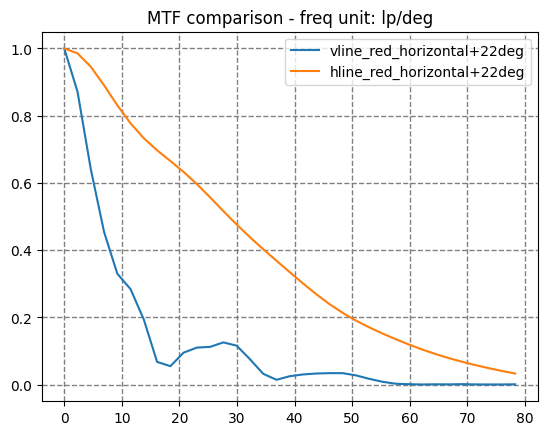

In [4]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_test_red_horizontal+22deg_22m_rot.png', 0, False, 35)
freq2, mtf2 = calc_mtf('h_test_red_horizontal+22deg_22m_rot.png', 90, False, 35)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='vline_red_horizontal+22deg')
plt.plot(freq2, mtf2, label='hline_red_horizontal+22deg')
plt.legend()
# print("freq", freq)
# print("mtf", mtf)

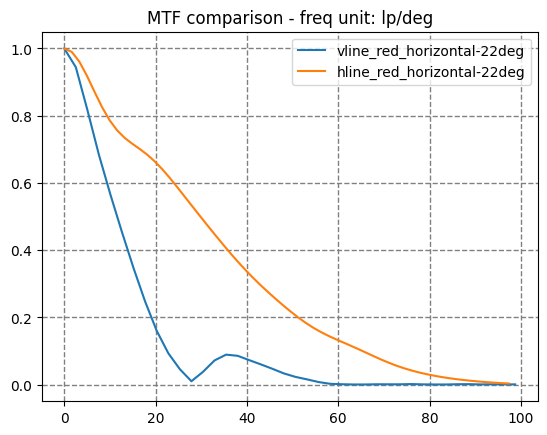

In [5]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_test_red_horizontal-22deg_22m_rot.png', 0, False, 40)
freq2, mtf2 = calc_mtf('h_test_red_horizontal-22deg_22m_rot.png', 90, False, 60)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='vline_red_horizontal-22deg')
plt.plot(freq2, mtf2, label='hline_red_horizontal-22deg')
plt.legend()
# print("freq", freq)
# print("mtf", mtf)

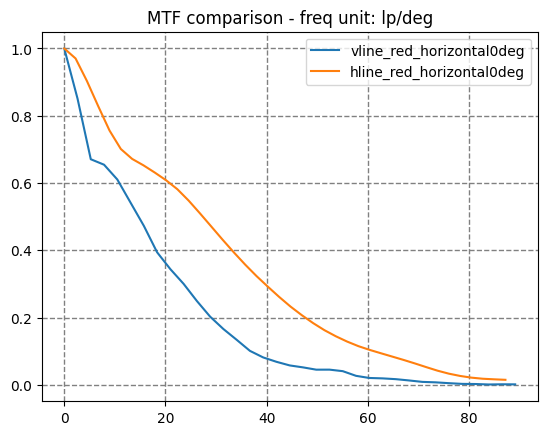

In [6]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_test_red_horizontal0deg_22m_rot.png', 0, False, 35)
freq2, mtf2 = calc_mtf('h_test_red_horizontal0deg_22m_rot.png', 90, False, 40)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='vline_red_horizontal0deg')
plt.plot(freq2, mtf2, label='hline_red_horizontal0deg')
plt.legend()
# print("freq", freq)
# print("mtf", mtf)

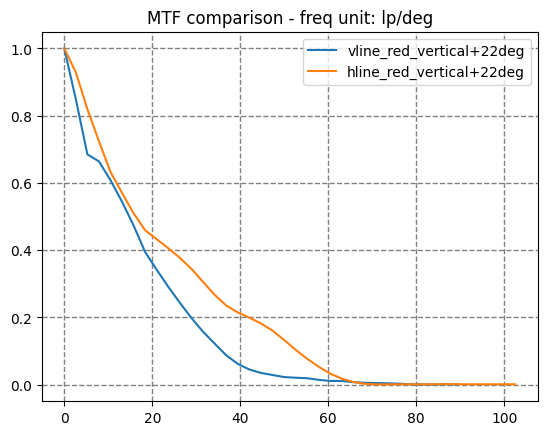

In [7]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_test_red_vertical+22deg_22m_rot.png', 0, False, 35)
freq2, mtf2 = calc_mtf('h_test_red_vertical+22deg_22m_rot.png', 90, False, 40)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='vline_red_vertical+22deg')
plt.plot(freq2, mtf2, label='hline_red_vertical+22deg')
plt.legend()
# print("freq", freq)
# print("mtf", mtf)

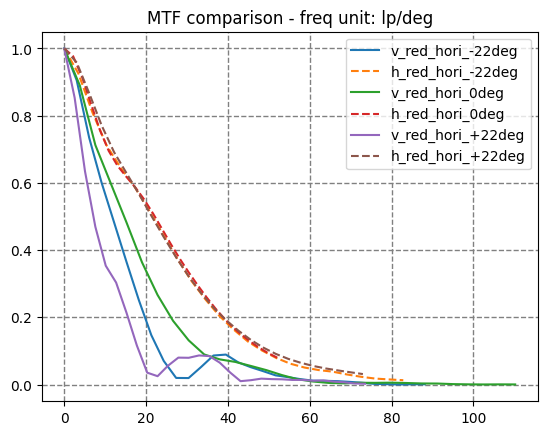

In [19]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_red_hori_-22deg_3333_rot.png', 0, False, 30)
freq2, mtf2 = calc_mtf('h_red_hori_-22deg_3333_rot.png', 90, False, 25)
freq3, mtf3 = calc_mtf('v_red_hori_0deg_1111_rot.png', 0, False, 30)
freq4, mtf4 = calc_mtf('h_red_hori_0deg_1111_rot.png', 90, False, 25)
freq5, mtf5 = calc_mtf('v_red_hori_+22deg_2222_rot.png', 0, False, 30)
freq6, mtf6 = calc_mtf('h_red_hori_+22deg_2222_rot.png', 90, False, 25)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='v_red_hori_-22deg')
plt.plot(freq2, mtf2, label='h_red_hori_-22deg', linestyle="--")
plt.plot(freq3, mtf3, label='v_red_hori_0deg')
plt.plot(freq4, mtf4, label='h_red_hori_0deg', linestyle="--")
plt.plot(freq5, mtf5, label='v_red_hori_+22deg')
plt.plot(freq6, mtf6, label='h_red_hori_+22deg', linestyle="--")
plt.legend()

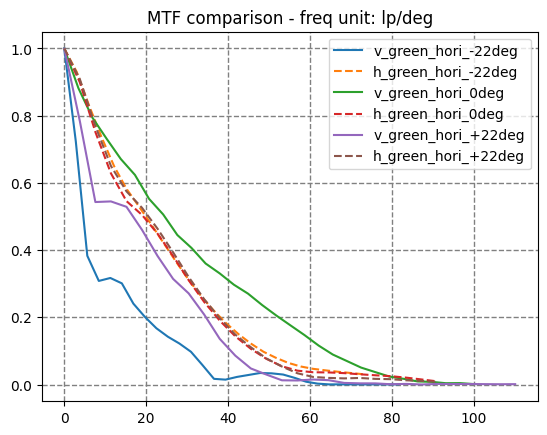

In [18]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_green_hori_-22deg_1666_rot.png', 0, False, 30)
freq2, mtf2 = calc_mtf('h_green_hori_-22deg_1666_rot.png', 90, False, 25)
freq3, mtf3 = calc_mtf('v_green_hori_0deg_1111_rot.png', 0, False, 30)
freq4, mtf4 = calc_mtf('h_green_hori_0deg_1111_rot.png', 90, False, 25)
freq5, mtf5 = calc_mtf('v_green_hori_+22deg_1111_rot.png', 0, False, 30)
freq6, mtf6 = calc_mtf('h_green_hori_+22deg_1111_rot.png', 90, False, 25)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='v_green_hori_-22deg')
plt.plot(freq2, mtf2, label='h_green_hori_-22deg', linestyle="--")
plt.plot(freq3, mtf3, label='v_green_hori_0deg')
plt.plot(freq4, mtf4, label='h_green_hori_0deg', linestyle="--")
plt.plot(freq5, mtf5, label='v_green_hori_+22deg')
plt.plot(freq6, mtf6, label='h_green_hori_+22deg', linestyle="--")
plt.legend()

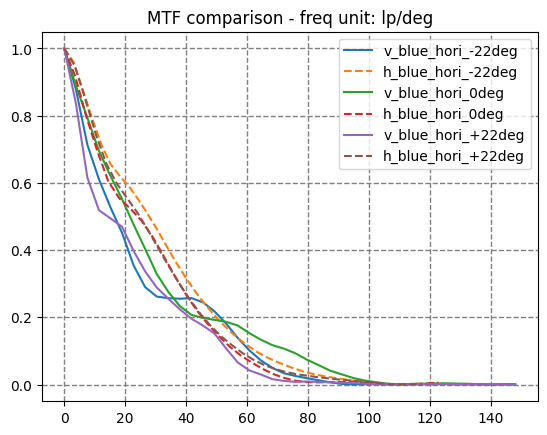

In [17]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_blue_hori_-22deg_4444_rot.png', 0, False, 40)
freq2, mtf2 = calc_mtf('h_blue_hori_-22deg_4444_rot.png', 90, False, 35)
freq3, mtf3 = calc_mtf('v_blue_hori_0deg_4444_rot.png', 0, False, 40)
freq4, mtf4 = calc_mtf('h_blue_hori_0deg_4444_rot.png', 90, False, 35)
freq5, mtf5 = calc_mtf('v_blue_hori_+22deg_5555_rot.png', 0, False, 40)
freq6, mtf6 = calc_mtf('h_blue_hori_+22deg_5555_rot.png', 90, False, 35)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='v_blue_hori_-22deg')
plt.plot(freq2, mtf2, label='h_blue_hori_-22deg', linestyle="--")
plt.plot(freq3, mtf3, label='v_blue_hori_0deg')
plt.plot(freq4, mtf4, label='h_blue_hori_0deg', linestyle="--")
plt.plot(freq5, mtf5, label='v_blue_hori_+22deg')
plt.plot(freq6, mtf6, label='h_blue_hori_+22deg', linestyle="--")
plt.legend()

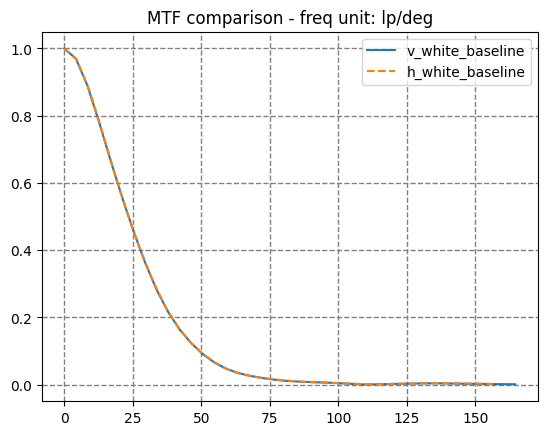

In [23]:
plt.title('MTF comparison - freq unit: lp/deg')
freq1, mtf1 = calc_mtf('v_white_baseline_222_rot.png', 0, False, 40)
freq2, mtf2 = calc_mtf('h_white_baseline_222_rot.png', 90, False, 35)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(freq1, mtf1, label='v_white_baseline')
plt.plot(freq2, mtf2, label='h_white_baseline', linestyle="--")
plt.legend()